<a href="https://colab.research.google.com/github/Sriramadasu/-COVID-Detection-using-X-ray-image-dataset-using-CNN/blob/main/COVID_Detection_using_Chest_X_ray_images_using_CNN(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169

In [6]:
!pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip *.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [18]:
def generate_dataset_from_directory(folder_path, size = 256,batch_size = 8): 
    image_generator = ImageDataGenerator(
        samplewise_center=True, 
        samplewise_std_normalization= True,
        #rescale=1./255,
        validation_split = 0.3
    )
    #creating train and test dataset 
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=False,
        seed=123,
        subset="training"
    )
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=False,
        seed=123,
        subset="validation"
    )
    indices=train_data.class_indices
  
    return train_data, val_data,indices

In [19]:
folder_path = '/content/COVID-19_Radiography_Dataset/'
train_data, val_data, indices= generate_dataset_from_directory(
    folder_path, size = 256,batch_size = 8)

Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.


# **Data Analysis**

In [20]:
class_names = train_data.class_indices
print(class_names)


{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [21]:
classes = list(class_names.keys())
print(classes)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [22]:
images,labels = next(train_data)
labels = np.argmax(labels, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in labels]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow wi

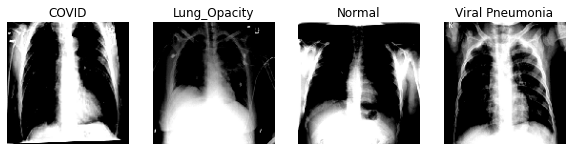

In [ ]:
plt.figure(figsize=(10, 10))
for image in images:
    j  = 0
    for i in range(4):
        ax = plt.subplot(1, 4, i+1)
        for k in range(len(labels)):
            if labels[k] == j:
                plt.imshow(images[k])
                plt.title(classes[i])
                plt.axis("off")
                break
        j = j+1
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Raw Chest X Ray Image')

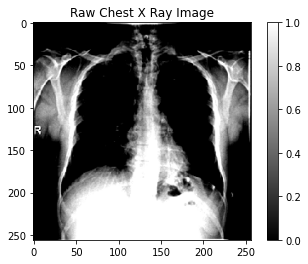

In [53]:
raw_image = images[k]
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

In [55]:
all_items,dirs,files = next(os.walk(folder_path))

In [56]:
import seaborn as sns
image_in_classes = []
for i in range(len(dirs)):
    print(dirs[i])
    k=(os.path.join(folder_path,dirs[i]))
    k=os.path.join(k,'images/')
    # print(os.listdir(os.path.join(folder_path,dirs[i])))
    # no_of_images =len(os.listdir(os.path.join(folder_path,dirs[i])))
    print(k)
    no_of_images =len(os.listdir(k))
    image_in_classes.append(no_of_images)
df_data = {'class': dirs,'counts': image_in_classes}
classes_df = pd.DataFrame(df_data) 

COVID
/content/COVID-19_Radiography_Dataset/COVID/images/
Lung_Opacity
/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/
Viral Pneumonia
/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/
Normal
/content/COVID-19_Radiography_Dataset/Normal/images/


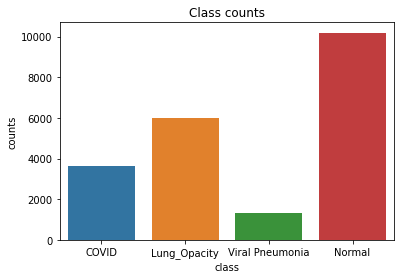

In [57]:
sns.barplot(x = 'class', y = 'counts',data = classes_df)
plt.title('Class counts')
plt.show()

#**MODEL TRAINING**

In [8]:
def cnn_model(train_data,test_data, epochs,size):
    print("----Building the model----")
    i = Input(shape=(size,size,3))
    x = BatchNormalization()(i)
    x = Conv2D(32,3, activation= 'relu')(i)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(4, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 8,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs

In [9]:
epochs = 30
r,model,n_epochs = cnn_model(train_data, val_data,epochs,256)

----Building the model----
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                              

In [59]:
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

1588/1588 [==============================] - 49s 31ms/step - loss: 0.4632 - accuracy: 0.8302
Test Accuracy using CNN: 83.02%
3704/3704 [==============================] - 87s 24ms/step - loss: 0.4209 - accuracy: 0.8473
Train Accuracy using CNN: 84.73%


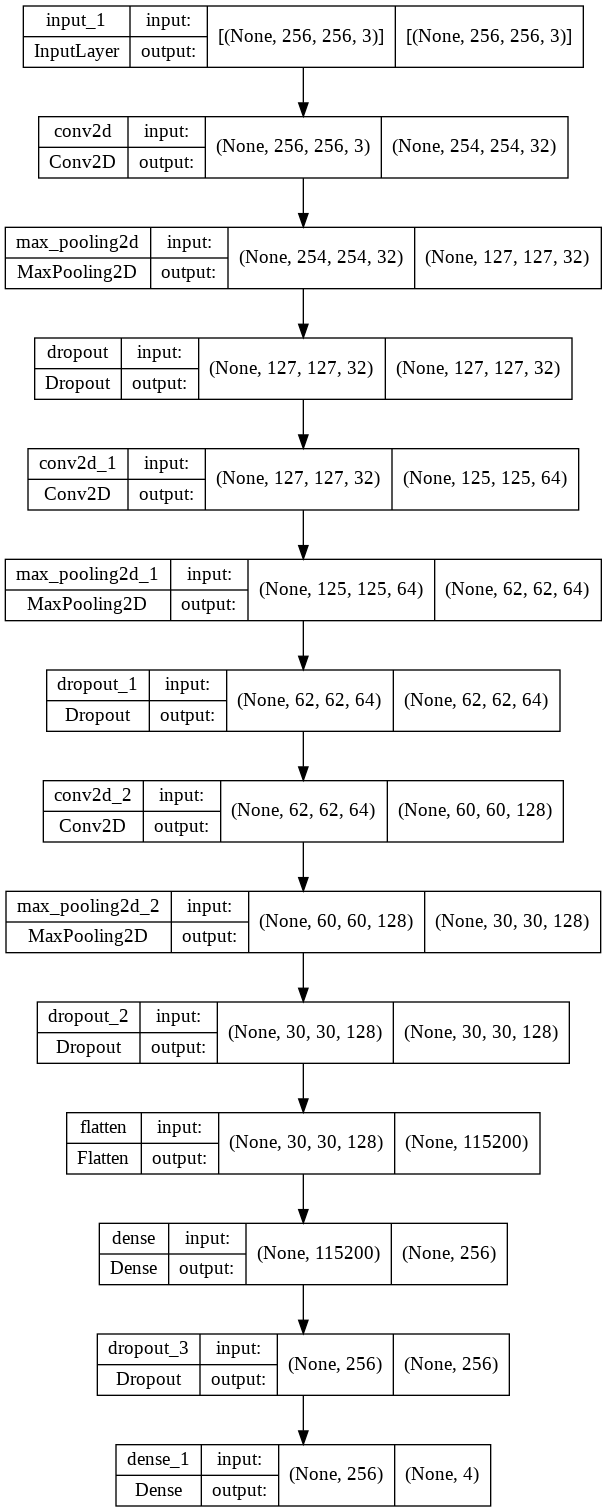

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import shutil
shutil.copy('/content/cnn_model.h5','/content/drive/MyDrive/model/cnn_model_v2.h5')

'/content/drive/MyDrive/model/cnn_model_v2.h5'

In [74]:
from tensorflow import keras
cnn_model = keras.models.load_model('/content/drive/MyDrive/model/cnn_model_v2.h5')

#**CONFUSION MATRIX FOR TEST DATASET**


In [79]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = cnn_model.predict_generator(val_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(val_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(val_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[1571  288  302    8]
 [ 145 2807  648    7]
 [ 141  419 5516   39]
 [  33   22  104  648]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.83      0.72      0.77      2169
   Lung_Opacity       0.79      0.78      0.79      3607
         Normal       0.84      0.90      0.87      6115
Viral Pneumonia       0.92      0.80      0.86       807

       accuracy                           0.83     12698
      macro avg       0.85      0.80      0.82     12698
   weighted avg       0.83      0.83      0.83     12698



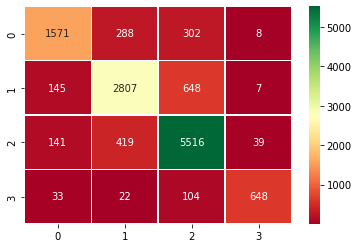

In [81]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

#**CONFUSION MATRIX FOR TRAIN DATA**

In [78]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = cnn_model.predict_generator(train_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(train_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(train_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[ 3138   617  1308     0]
 [  279  6719  1418     1]
 [  173   504 13585     7]
 [   14    16   187  1666]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.87      0.62      0.72      5063
   Lung_Opacity       0.86      0.80      0.83      8417
         Normal       0.82      0.95      0.88     14269
Viral Pneumonia       1.00      0.88      0.94      1883

       accuracy                           0.85     29632
      macro avg       0.89      0.81      0.84     29632
   weighted avg       0.85      0.85      0.84     29632



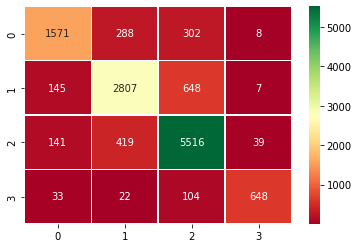

In [82]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

**ROC CURVE**

ROC AUC score: 0.8665483732252419


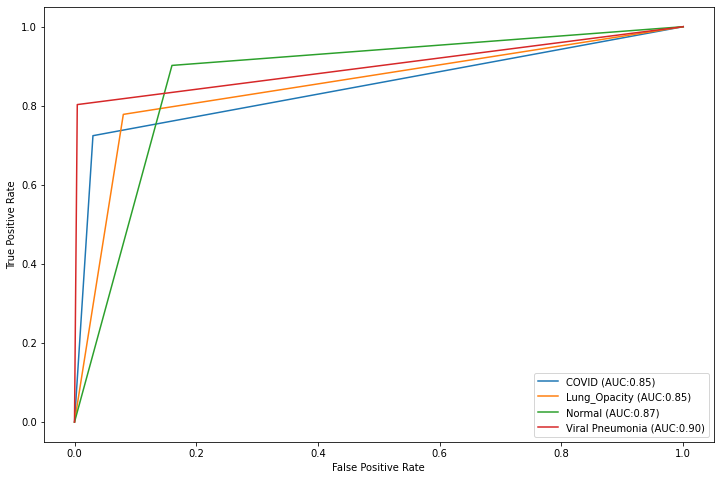

In [83]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= list(val_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(val_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

#**Using VGGNet model**

In [85]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

image_size=256

base_VGG = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3),
                                       include_top=False, 
                                       weights='imagenet')
base_VGG.trainable = False

# Add some layers which we found to be 
VGG = tf.keras.Sequential([
        base_VGG,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
        ])

# Compile our model
VGG.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy', 'Recall', 'Precision'])
VGG.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 31,494,468
Trainable params: 16,779,780
Non-trainable params: 14,714,688
____________________________________

In [86]:
print(len(base_VGG.layers))

19


In [87]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath='best_weights.VGG', 
                             save_best_only=True 
                             #save_weights_only=True
                            )
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, 
                              patience=2, 
                              verbose=2, 
                              mode='max')

In [88]:
histVGG = VGG.fit(
    train_data, 
    steps_per_epoch = 128, 
    epochs = 30, 
    validation_data = val_data, 
    callbacks= [checkpoint, lr_reduce])

Epoch 1/30
128/128 [==============================] - 128s 982ms/step - loss: 2.1369 - accuracy: 0.5117 - recall: 0.4912 - precision: 0.5234 - val_loss: 0.4492 - val_accuracy: 0.7363 - val_recall: 0.4460 - val_precision: 0.8774 - lr: 0.0010
Epoch 2/30
128/128 [==============================] - 123s 970ms/step - loss: 0.5585 - accuracy: 0.5205 - recall: 0.4482 - precision: 0.5537 - val_loss: 0.4300 - val_accuracy: 0.5947 - val_recall: 0.5828 - val_precision: 0.6103 - lr: 0.0010
Epoch 3/30
128/128 [==============================] - 121s 948ms/step - loss: 0.4180 - accuracy: 0.6172 - recall: 0.5176 - precision: 0.6650 - val_loss: 0.4715 - val_accuracy: 0.6688 - val_recall: 0.6611 - val_precision: 0.6915 - lr: 0.0010
Epoch 4/30
128/128 [==============================] - 122s 960ms/step - loss: 0.4167 - accuracy: 0.6025 - recall: 0.5039 - precision: 0.6442 - val_loss: 0.2914 - val_accuracy: 0.7389 - val_recall: 0.7203 - val_precision: 0.7811 - lr: 0.0010
Epoch 5/30
128/128 [================

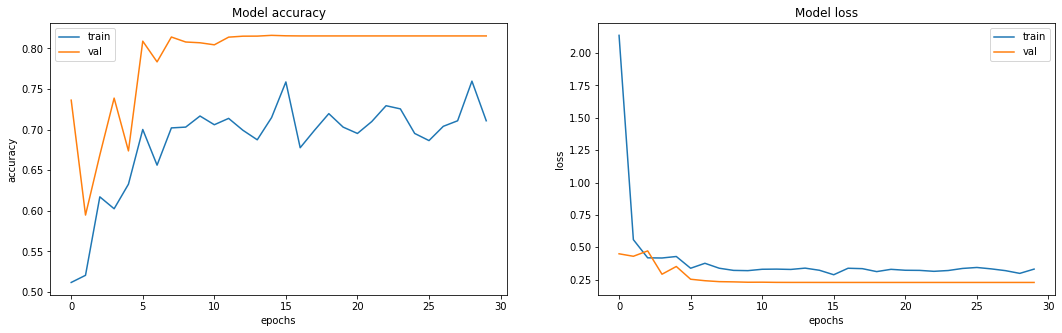

In [89]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(histVGG.history[element])
    axis[i].plot(histVGG.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [94]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = VGG.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(val_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(val_data.classes, y_pred, target_names=target_names))



Confusion Matrix
[[1038  609  515    7]
 [  50 2929  628    0]
 [  18  390 5645   62]
 [   7    3   54  743]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.93      0.48      0.63      2169
   Lung_Opacity       0.75      0.81      0.78      3607
         Normal       0.83      0.92      0.87      6115
Viral Pneumonia       0.92      0.92      0.92       807

       accuracy                           0.82     12698
      macro avg       0.85      0.78      0.80     12698
   weighted avg       0.83      0.82      0.81     12698



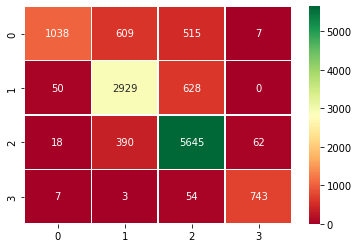

In [95]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

In [98]:
test_evaluation = VGG.evaluate(val_data)
print(f"Test Accuracy using CNN: {test_evaluation[1] * 100:.2f}%")

train_evaluation = VGG.evaluate(train_data)
print(f"Train Accuracy using CNN: {train_evaluation[1] * 100:.2f}%")

1588/1588 [==============================] - 115s 73ms/step - loss: 0.2278 - accuracy: 0.8155 - recall: 0.7901 - precision: 0.8340
Test Accuracy using CNN: 81.55%
3704/3704 [==============================] - 258s 70ms/step - loss: 0.2956 - accuracy: 0.7447 - recall: 0.6919 - precision: 0.7816
Train Accuracy using CNN: 74.47%


In [100]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = VGG.predict(train_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(train_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(train_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 1437  1781  1832    13]
 [  325  6418  1665     9]
 [  161  1301 12632   175]
 [   36    30   236  1581]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.73      0.28      0.41      5063
   Lung_Opacity       0.67      0.76      0.72      8417
         Normal       0.77      0.89      0.82     14269
Viral Pneumonia       0.89      0.84      0.86      1883

       accuracy                           0.74     29632
      macro avg       0.77      0.69      0.70     29632
   weighted avg       0.74      0.74      0.73     29632



ROC AUC score: 0.7941501223453159


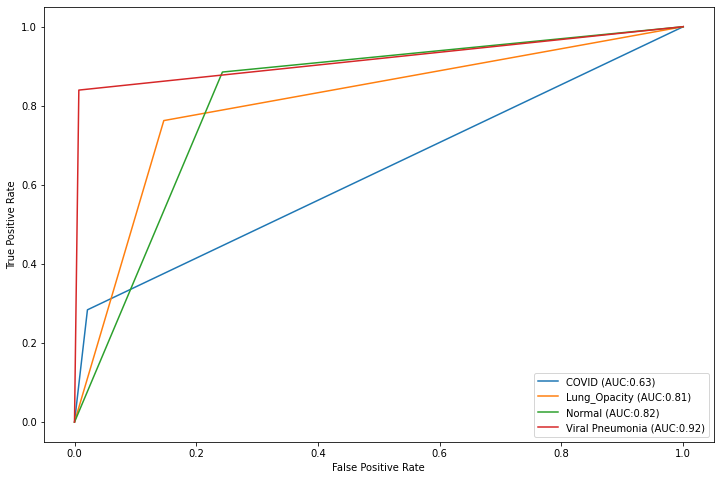

In [101]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(train_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## **USING RESNET**

In [102]:
def resnet_model(train_data,test_data, epochs,size):
#Building the model using Keras functional API
    print("----Building the model----")
    
    base_model = ResNet50(input_shape= (size,size,3), include_top=False)
#     base_model.trainable=False #freezing the layer


    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    out=Dense(4,activation='softmax')(x)

    model=Model(inputs=base_model.input,outputs=out) 
    # model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
    #model_checkpoint
    mc = ModelCheckpoint('resnet_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [early_stop,mc])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
epochs = 20
r,model,n_epochs = resnet_model(train_data, val_data,epochs,256)

----Building the model----
94781440/94765736 [==============================] - 1s 0us/step
----Training the network----
Epoch 1/20

Epoch 1: val_loss improved from inf to 1.89689, saving model to resnet_model.h5
926/926 - 464s - loss: 0.6194 - accuracy: 0.7413 - val_loss: 1.8969 - val_accuracy: 0.4809 - 464s/epoch - 501ms/step
Epoch 2/20

Epoch 2: val_loss did not improve from 1.89689
926/926 - 452s - loss: 0.1530 - accuracy: 0.9425 - val_loss: 3.1426 - val_accuracy: 0.4816 - 452s/epoch - 488ms/step
Epoch 3/20

Epoch 3: val_loss improved from 1.89689 to 1.36417, saving model to resnet_model.h5
926/926 - 452s - loss: 0.1425 - accuracy: 0.9519 - val_loss: 1.3642 - val_accuracy: 0.4817 - 452s/epoch - 489ms/step
Epoch 4/20

Epoch 4: val_loss improved from 1.36417 to 1.02408, saving model to resnet_model.h5
926/926 - 452s - loss: 0.1238 - accuracy: 0.9646 - val_loss: 1.0241 - val_accuracy: 0.5984 - 452s/epoch - 488ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 1.02408
926/926 -

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  return roc_auc_score(y_test, y_pred, average=average)

y_score=multiclass_roc_auc_score(val_data.classes,y_pred)

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(val_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
Y_pred = model.predict_generator(val_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cn=confusion_matrix(val_data.classes, y_pred)
print(cn)
#print(tf.confusion_matrix(train_data.classes, y_pred))
print('Classification Report')
target_names=list(train_data.class_indices.keys())
print(classification_report(val_data.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Confusion Matrix
[[1328   12  829    0]
 [ 987  688 1930    2]
 [ 472  360 5277    6]
 [ 392    0  110  305]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.42      0.61      0.50      2169
   Lung_Opacity       0.65      0.19      0.29      3607
         Normal       0.65      0.86      0.74      6115
Viral Pneumonia       0.97      0.38      0.54       807

       accuracy                           0.60     12698
      macro avg       0.67      0.51      0.52     12698
   weighted avg       0.63      0.60      0.56     12698



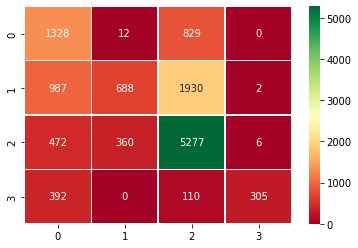

In [ ]:
# Use the heatmap function from the seaborn package
sns.heatmap(cn,annot=True,fmt="",cmap='RdYlGn',linewidths=0.30)

# Display the Pharma Sector Heatmap
plt.show()

ROC AUC score: 0.6738368502529903


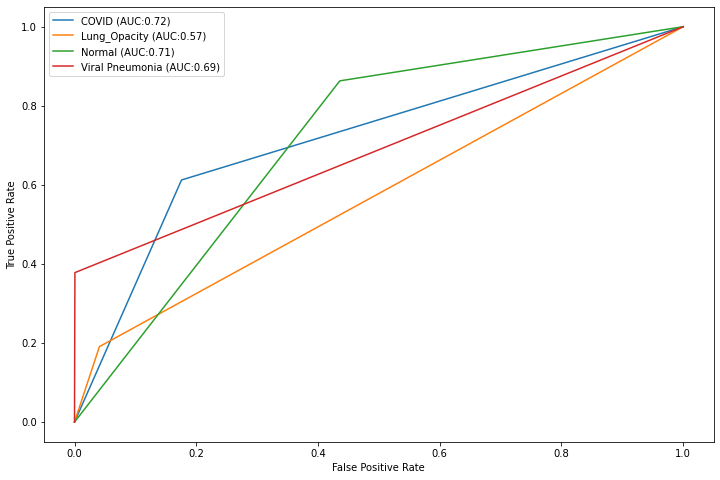

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(val_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.5502403125268125


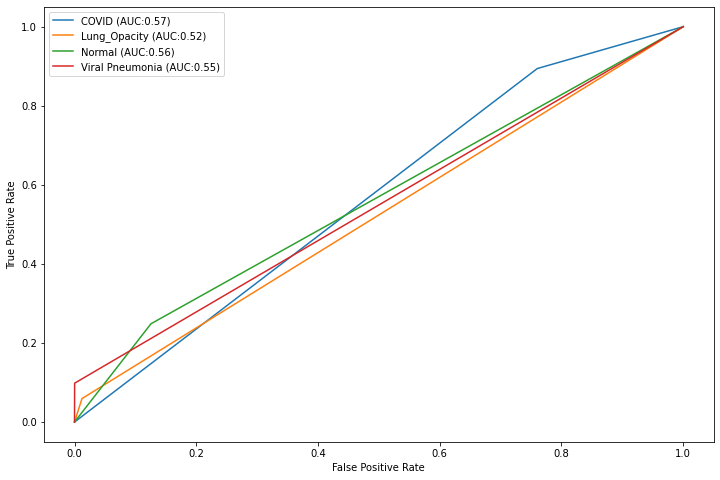

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
target= list(train_data.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(train_data.classes, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()